In [5]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import networkx as nx
import sys

# import DyGraph as dg
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
import DyGraph as dg
import matplotlib.pyplot as plt
import tqdm
import scipy

from scipy.stats import shapiro 
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima
from scipy.stats import boxcox
import statsmodels.api as sm
import pickle



Get daily AQI data


In [6]:
df  = []

for y in range(2014,2023):
    d_tmp = pd.read_csv(f"../data/AQI/daily_aqi_by_county_{y}.csv")
    d_tmp = d_tmp.loc[d_tmp['State Name'] == 'California']
    d_tmp = d_tmp[['county Name', 'Date', 'AQI']].pivot(index = 'Date', columns='county Name', values='AQI')
    df.append(d_tmp)

df = pd.concat(df)


df_t = df.ffill().copy()
df_t = df_t.dropna(axis=1)
#df_t = df_t.iloc[200:3000]
print(df_t.index[0])
print(df_t.index[-1])

2014-01-01
2022-10-31


In [8]:
df_t.columns

Index(['Alameda', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern',
       'Kings', 'Lake', 'Los Angeles', 'Madera', 'Marin', 'Mariposa',
       'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo',
       'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta',
       'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama',
       'Tulare', 'Tuolumne', 'Ventura', 'Yolo'],
      dtype='object', name='county Name')

<Axes: xlabel='yearmonth'>

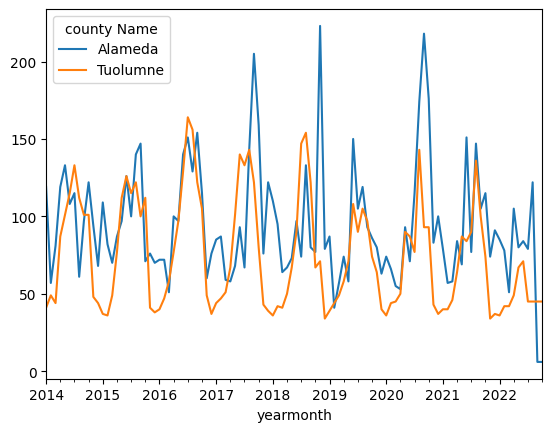

In [6]:
df_t.index = pd.to_datetime(df_t.index)
df_t['yearmonth'] = pd.to_datetime(df_t.index.year.astype(str) + '/' + df_t.index.month.astype(str) + '/01')
df_t[['yearmonth','Alameda', 'Tuolumne']].groupby('yearmonth').max().plot()


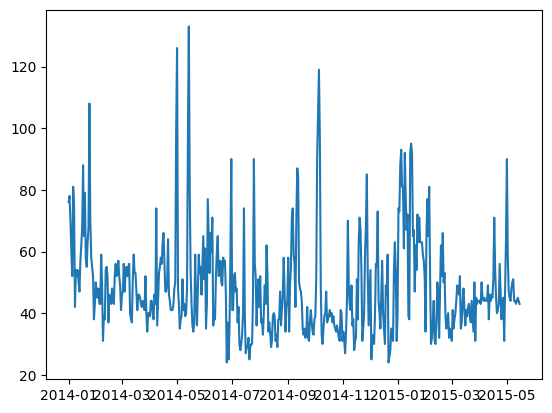

In [7]:


plt.plot(df_t.iloc[:500,5])


Do STL decomposition

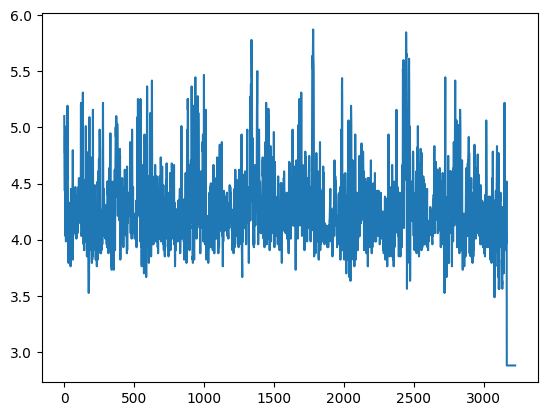

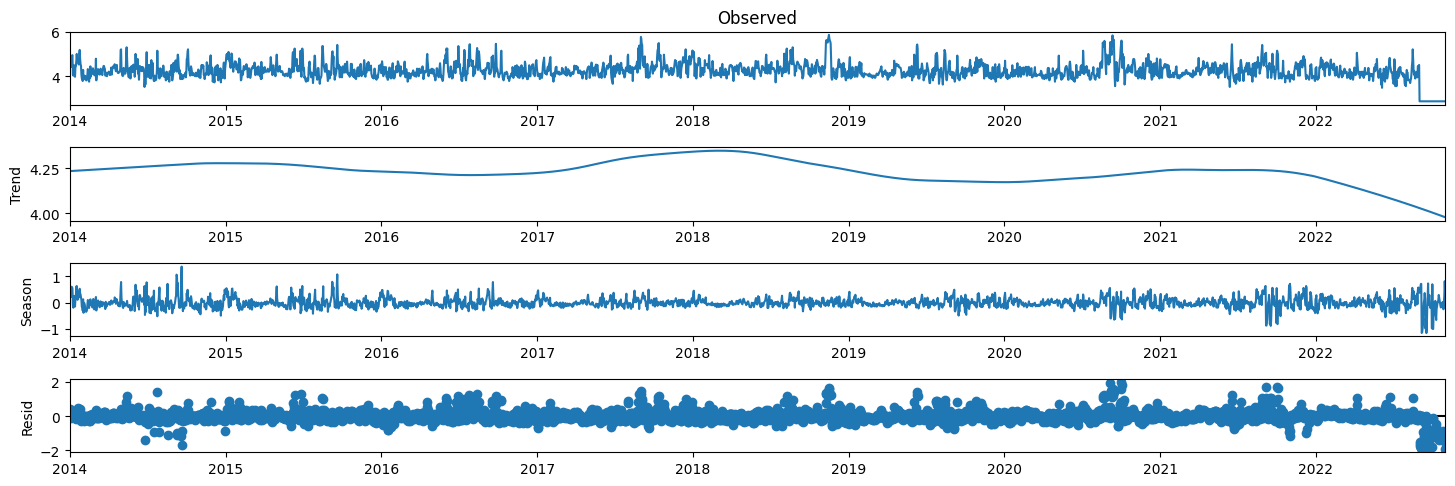

In [8]:
xt, _ = boxcox(df_t['Alameda']+10)
xt_df = pd.DataFrame(xt, index = df_t.index)
plt.plot(xt)

stl = STL(xt_df, seasonal=13, period = 365, robust = True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches((16, 5))
out = auto_arima(res.resid, seasonal=False)

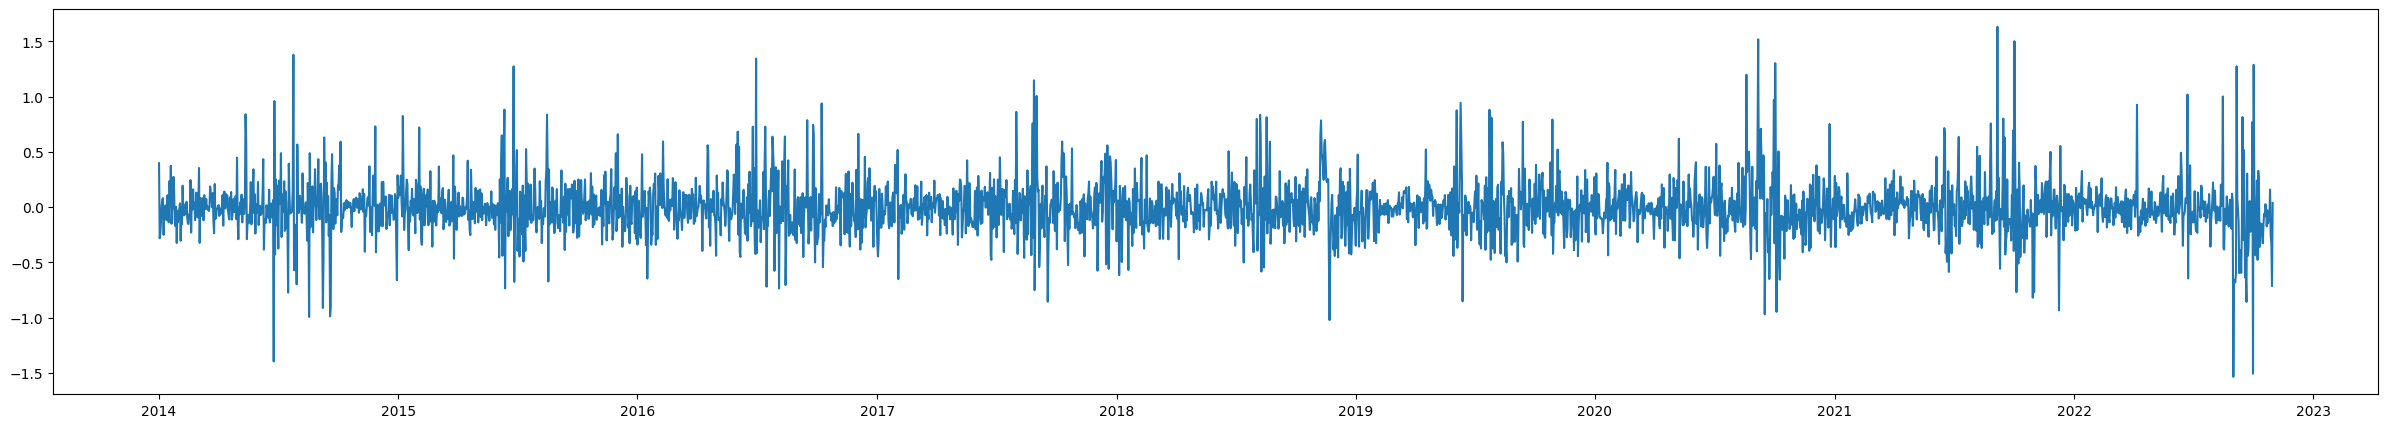

In [9]:
fig, ax = plt.subplots(1,1, figsize = (30,5))
ax.plot(out.resid())

In [13]:
out.resid().index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29',
               '2022-10-30', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=3226, freq=None)

In [10]:

shapiro(out.resid())

ShapiroResult(statistic=0.9179907441139221, pvalue=1.003511448867392e-38)

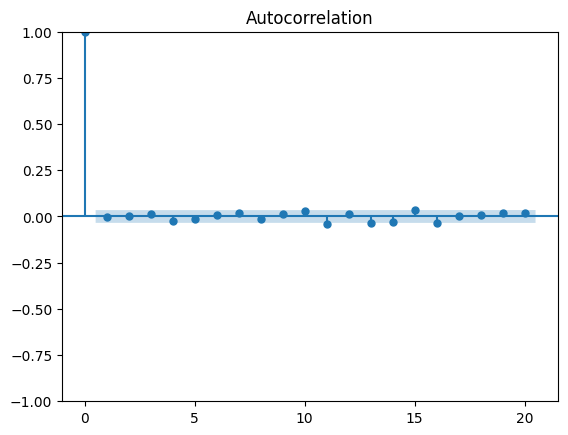

,lb_stat,lb_pvalue
1,0.007746,0.929870
2,0.008371,0.995823
3,0.733943,0.865193
4,2.573718,0.631486
5,3.014661,0.697725
6,3.157285,0.788863
7,4.538217,0.716111
8,5.345096,0.720135
9,5.747166,0.764932
10,8.790682,0.552077


In [11]:

sm.graphics.tsa.plot_acf(out.resid(), lags=20)
plt.show()
sm.stats.acorr_ljungbox(out.resid(), return_df=True,lags=10)

In [15]:
df_t[col]

Date
2014-01-01   2014-01-01
2014-01-02   2014-01-01
2014-01-03   2014-01-01
2014-01-04   2014-01-01
2014-01-05   2014-01-01
                ...    
2022-10-27   2022-10-01
2022-10-28   2022-10-01
2022-10-29   2022-10-01
2022-10-30   2022-10-01
2022-10-31   2022-10-01
Name: yearmonth, Length: 3226, dtype: datetime64[ns]

In [14]:
# Do decomposition for all 
ts_list = []

# time series

for col in df_t.columns:
    print(col)

    xt, _ = boxcox(df_t[col]+10)
    xt_df = pd.DataFrame(xt, index = df_t.index)
    # plt.plot(xt)
    stl = STL(xt_df, seasonal=13, period = 365, robust = True)
    res = stl.fit()
    out = auto_arima(res.resid, seasonal=False)
    
    ts_list.append(pd.DataFrame({col:np.array(pd.DataFrame(out.resid()).iloc[:,0])}, index = pd.DataFrame(out.resid()).index))

    

Alameda
Amador
Butte
Calaveras
Colusa
Contra Costa
El Dorado
Fresno
Glenn
Humboldt
Imperial
Inyo
Kern
Kings
Lake
Los Angeles
Madera
Marin
Mariposa
Mendocino
Merced
Mono
Monterey
Napa
Nevada
Orange
Placer
Riverside
Sacramento
San Benito
San Bernardino
San Diego
San Francisco
San Joaquin
San Luis Obispo
San Mateo
Santa Barbara
Santa Clara
Santa Cruz
Shasta
Siskiyou
Solano
Sonoma
Stanislaus
Sutter
Tehama
Tulare
Tuolumne
Ventura
Yolo
yearmonth


TypeError: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [16]:
# Merge
ts_df = pd.concat(ts_list)

In [24]:
from functools import reduce
ts_df = reduce(lambda df1,df2: pd.merge(df1,df2,right_index = True, left_index = True), ts_list)

In [29]:
ts_df.shape

(3226, 50)

In [50]:
ts_df[10:3160].shape[0] %90 == 0

True

In [44]:

# with open(f'../data/AQI/cleaned_aqi.pkl', 'wb') as handle:
#     pickle.dump(ts_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [2]:
with open(f'../data/AQI/cleaned_aqi.pkl', 'rb') as handle:
    ts_df = pickle.load(handle)

scaler = StandardScaler()
ts_df_scaled = scaler.fit_transform(ts_df)



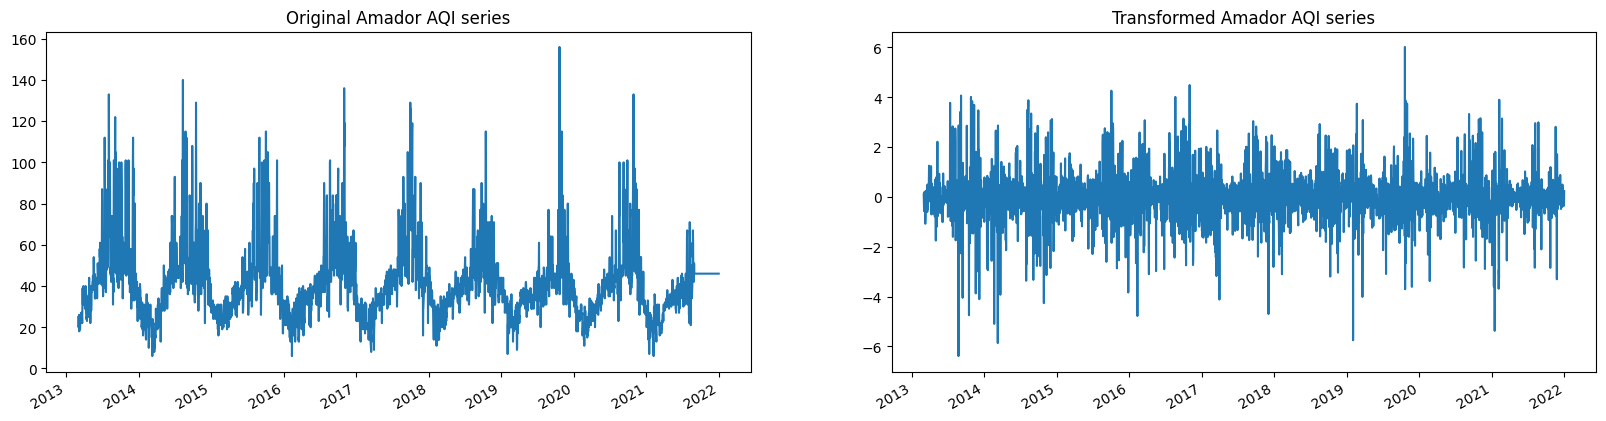

In [46]:
fig, ax = plt.subplots(1,2,figsize = (20,5))
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

ax[0].plot(pd.to_datetime(df_t.index), df_t.iloc[:,1])
ax[0].set_title("Original Amador AQI series")
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax[1].plot(pd.to_datetime(ts_df.index), ts_df_scaled[:,1])
ax[1].set_title("Transformed Amador AQI series")
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.autofmt_xdate()

In [47]:
shapiro_test = []
ljunbgox_test = []
lowest_pval = []
for col in ts_df.columns:
    shapiro_test.append(shapiro(ts_df[col]).pvalue)
    out = sm.stats.acorr_ljungbox(ts_df[col], return_df=True,lags=10)
    ljunbgox_test.append(out)
    lowest_pval.append(out['lb_pvalue'].min())


In [48]:
np.sum(np.array(lowest_pval)<0.05)/len(lowest_pval)

0.3

c:\Users\ragna\anaconda3\envs\DyGraph\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


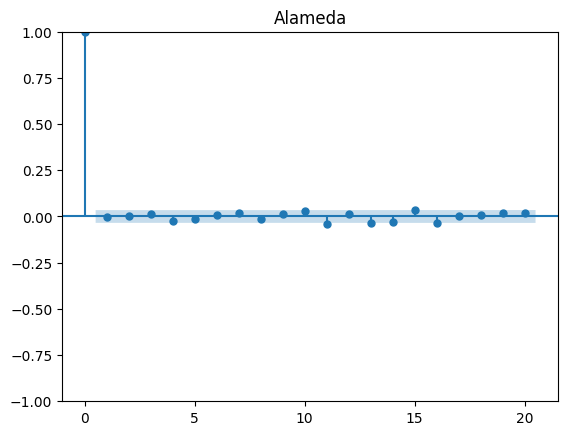

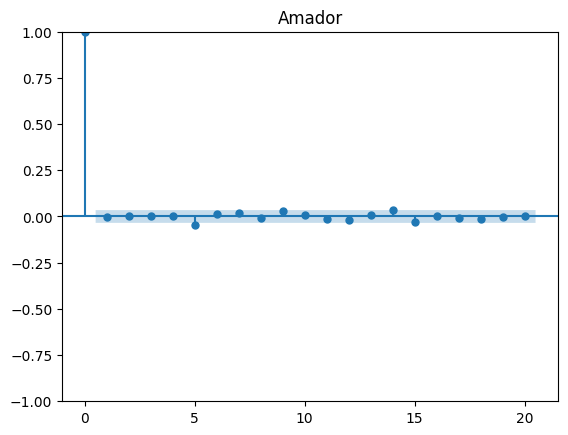

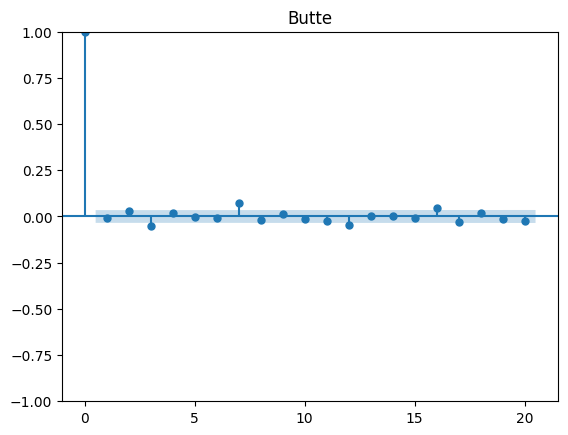

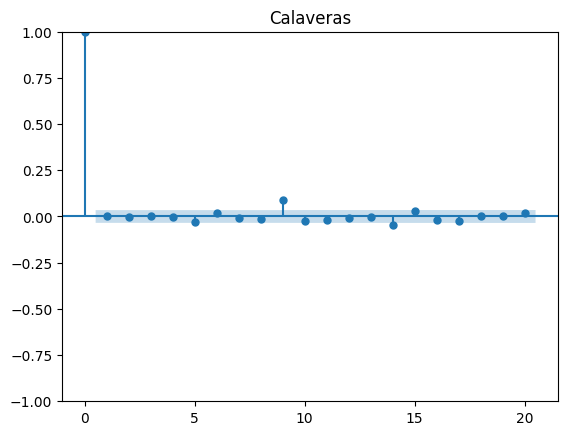

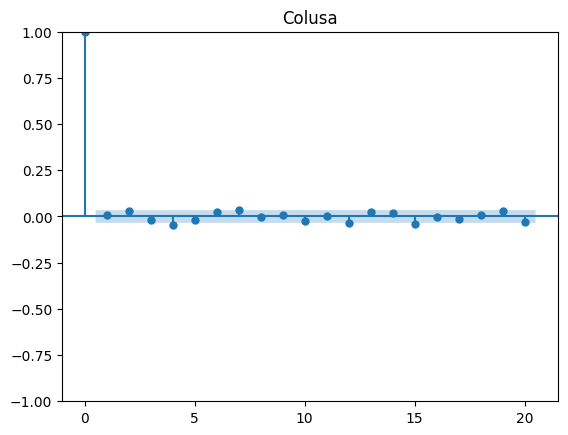

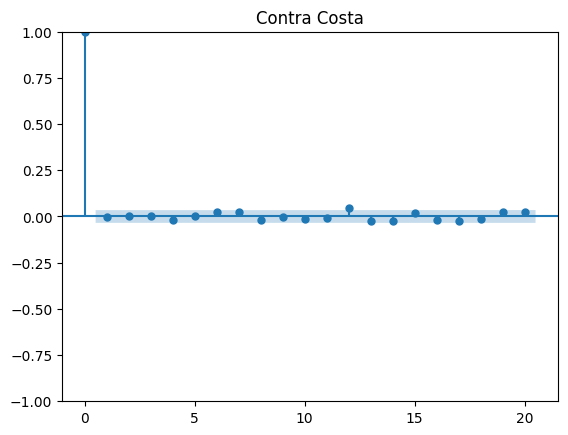

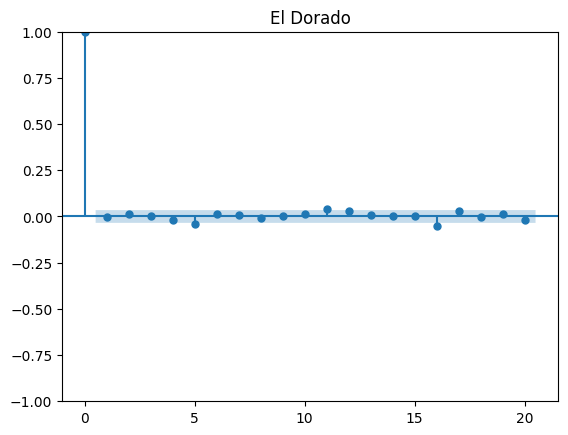

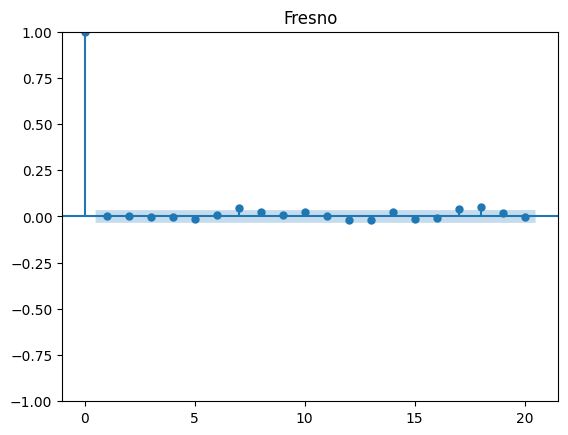

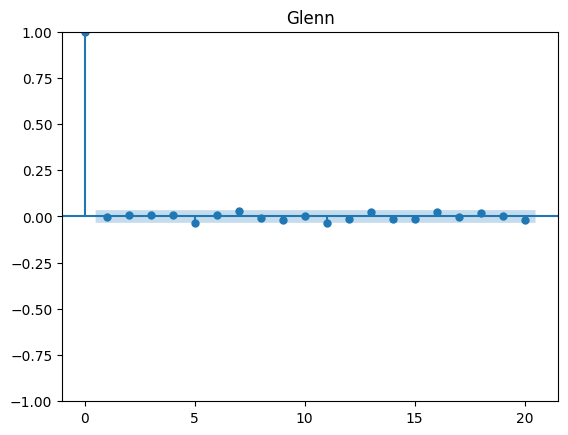

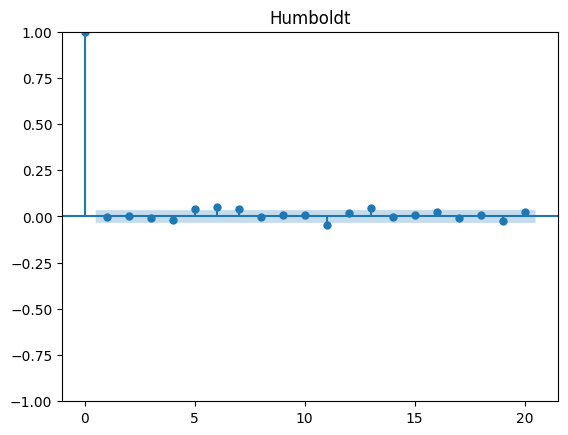

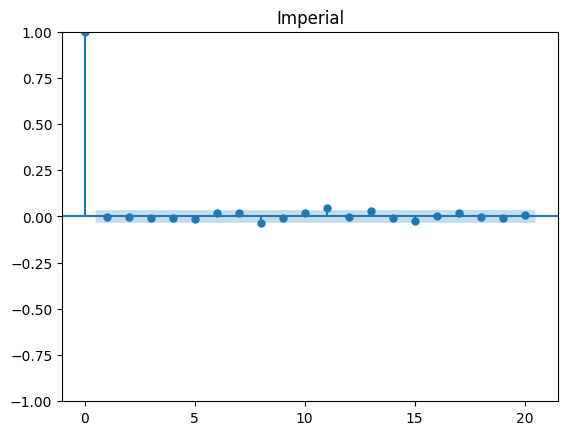

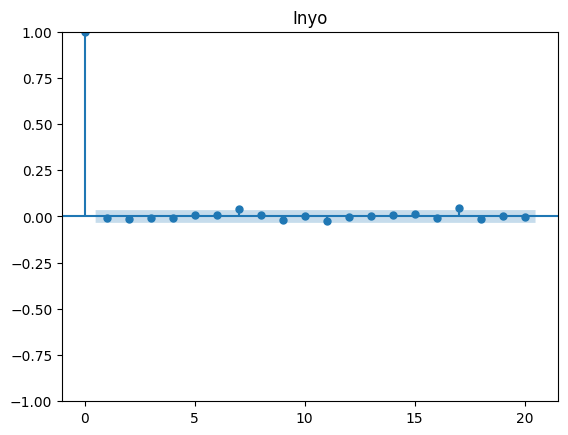

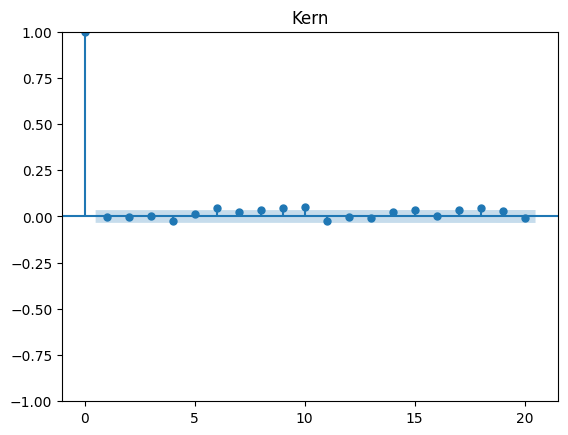

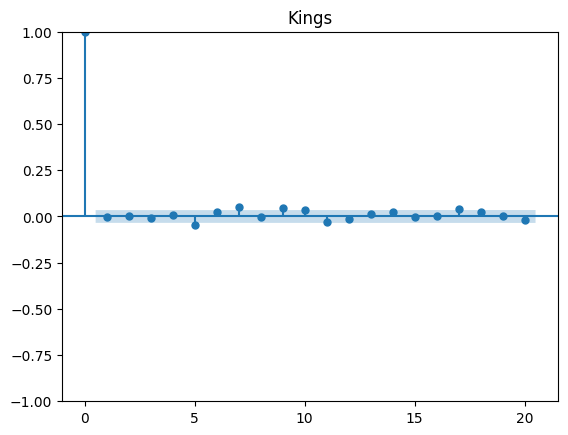

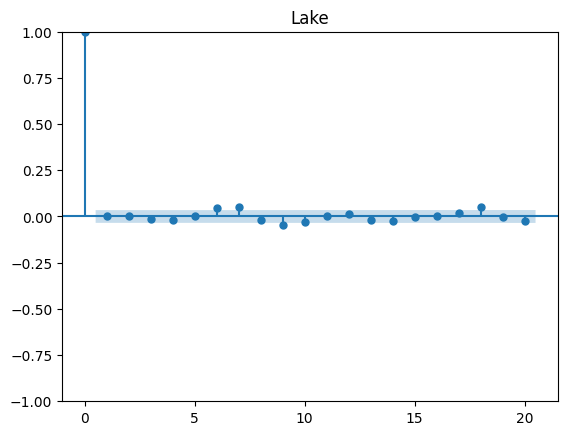

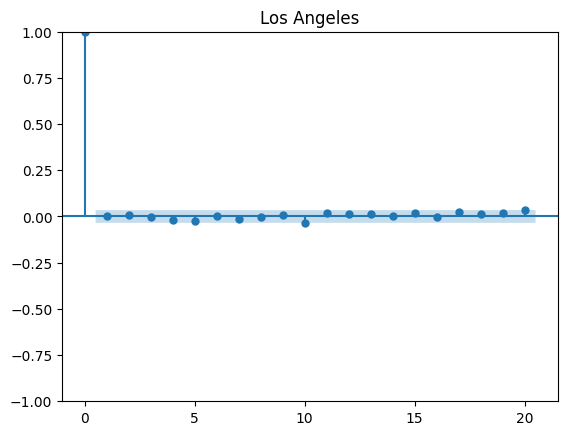

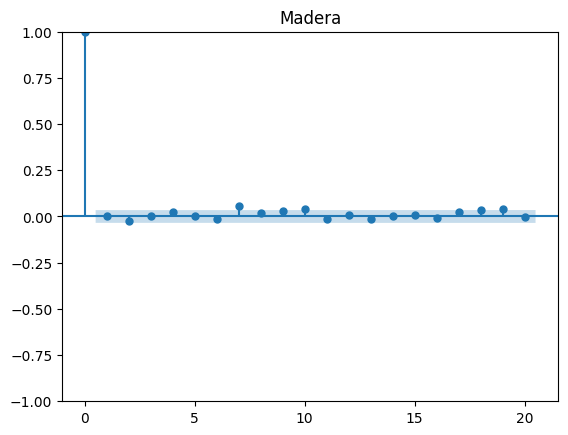

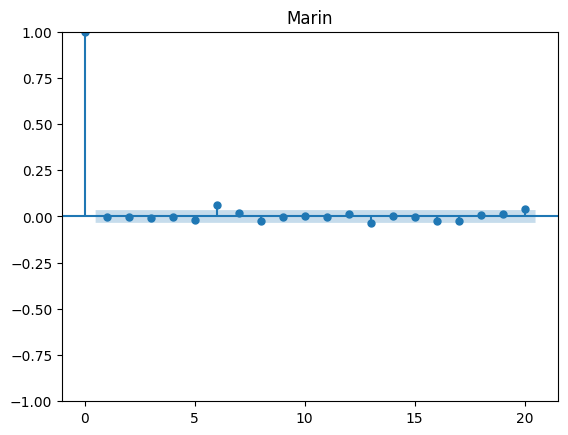

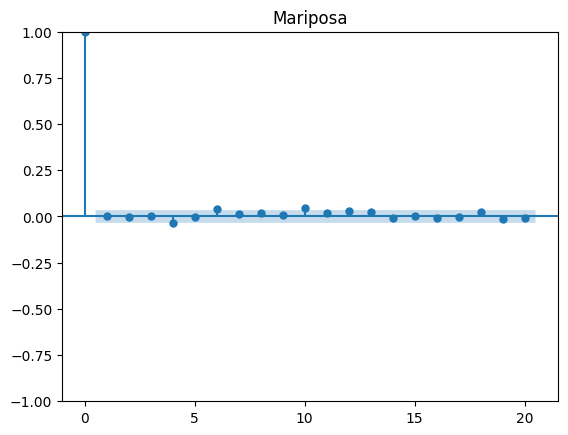

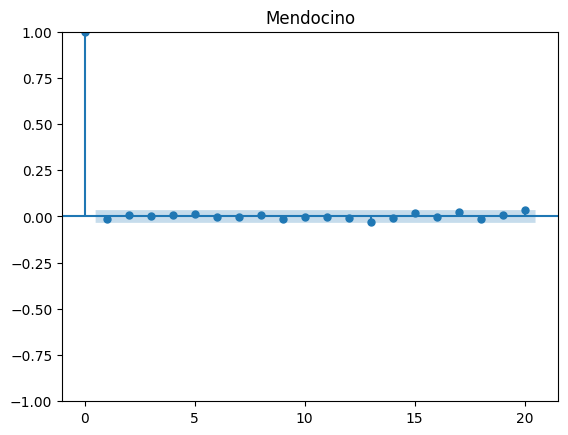

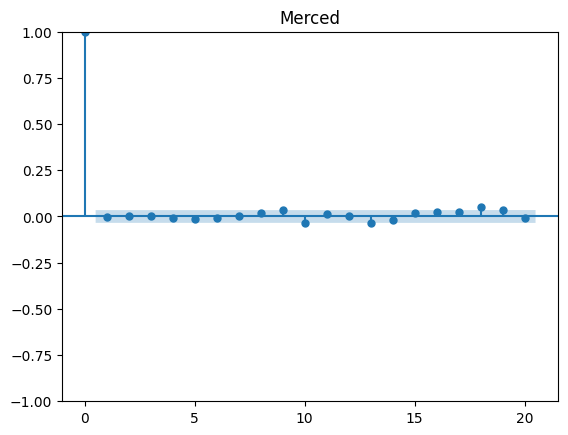

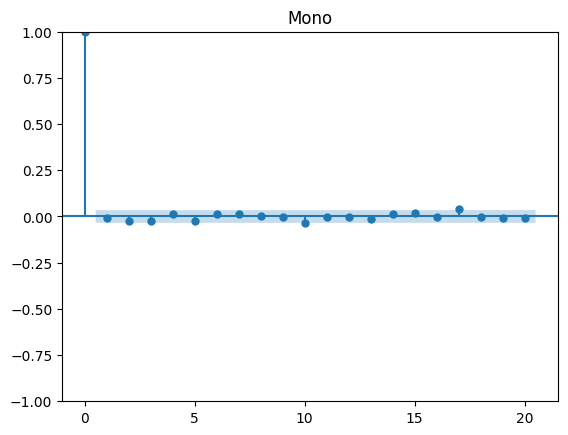

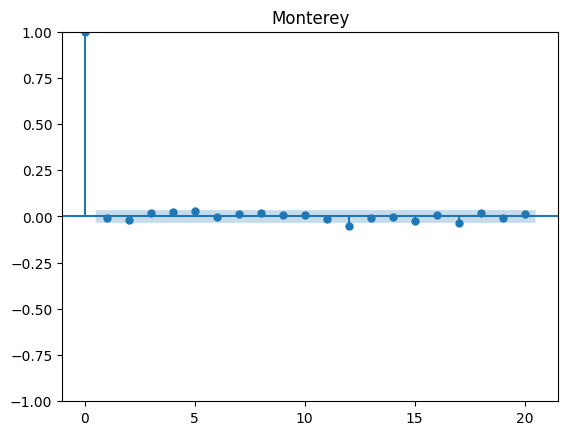

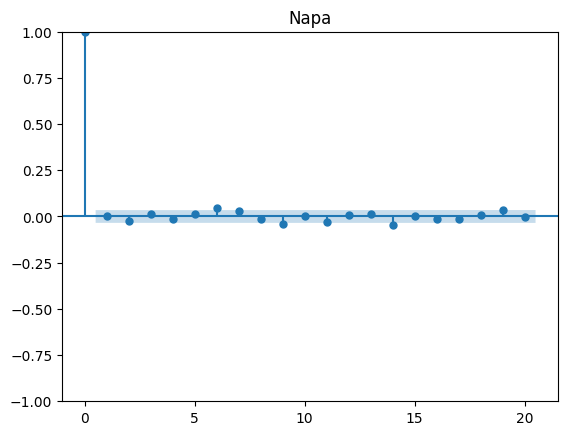

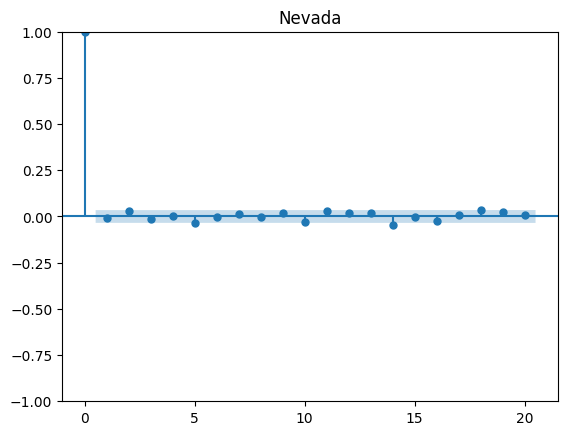

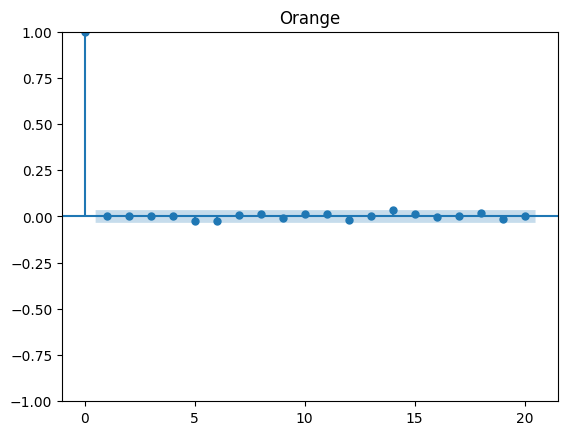

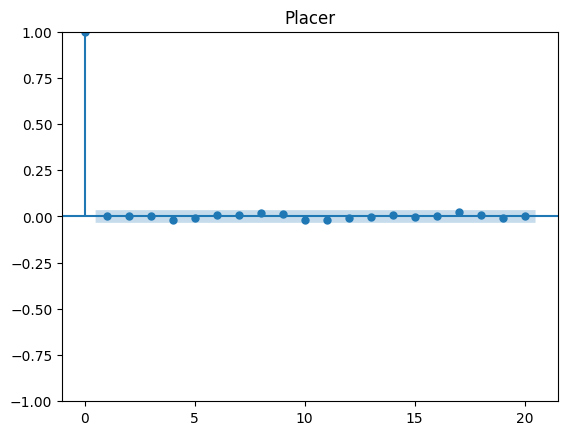

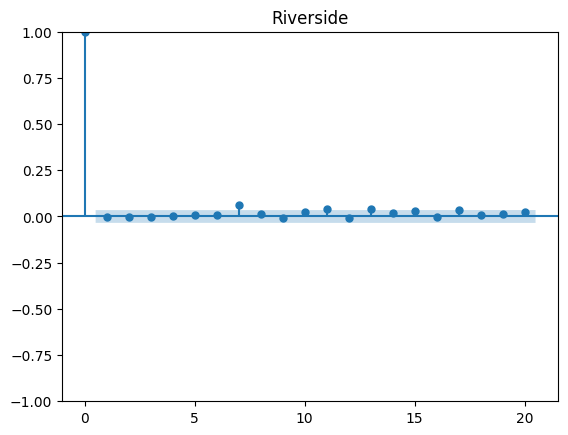

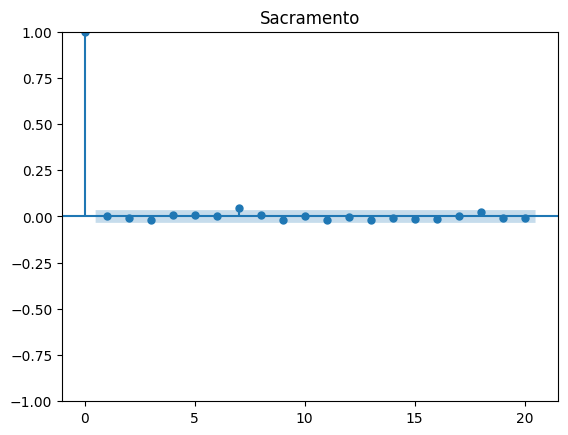

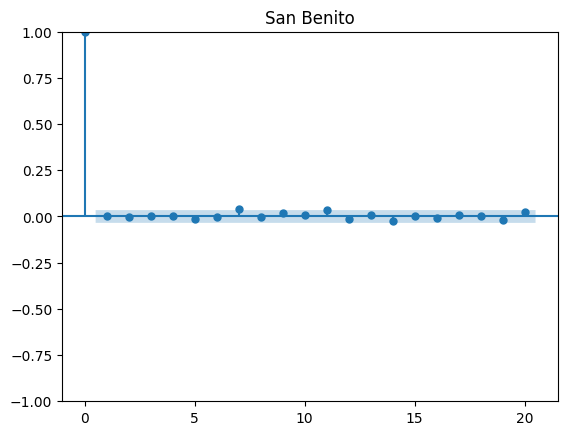

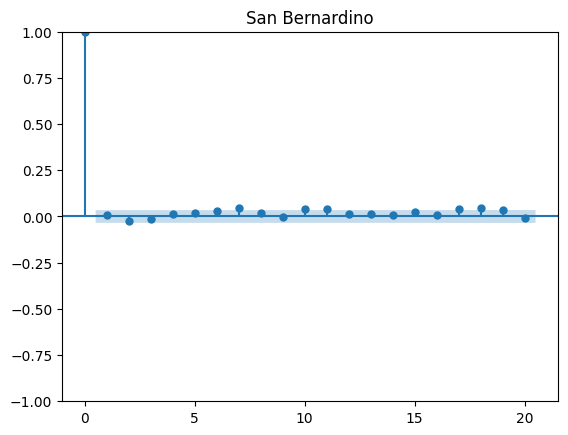

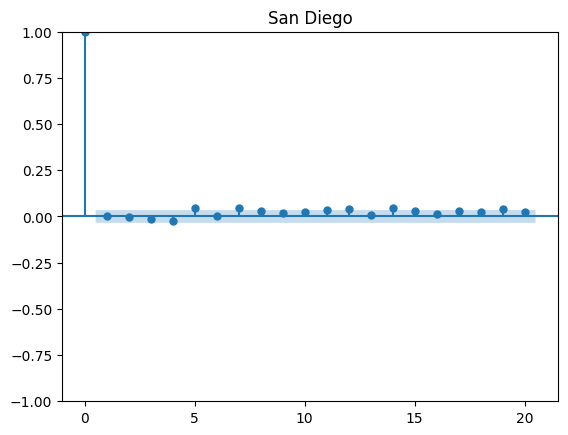

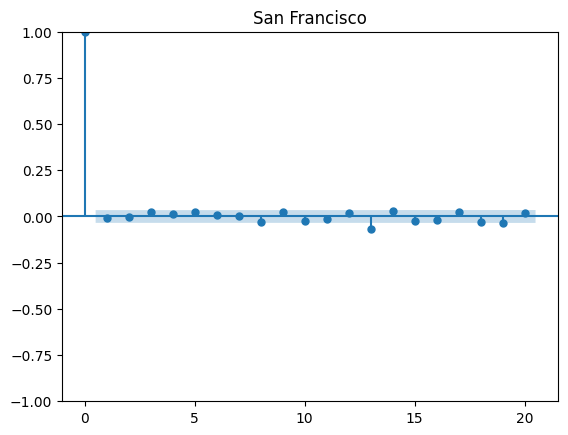

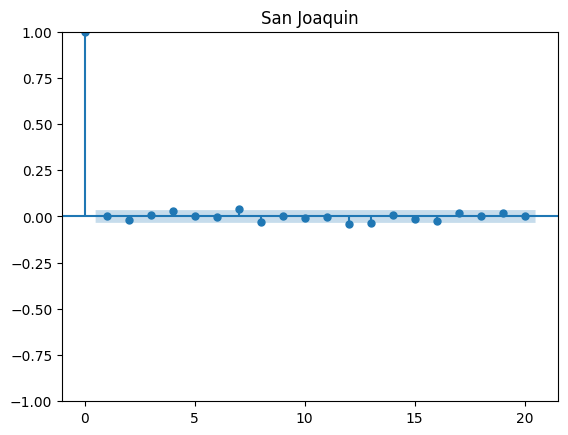

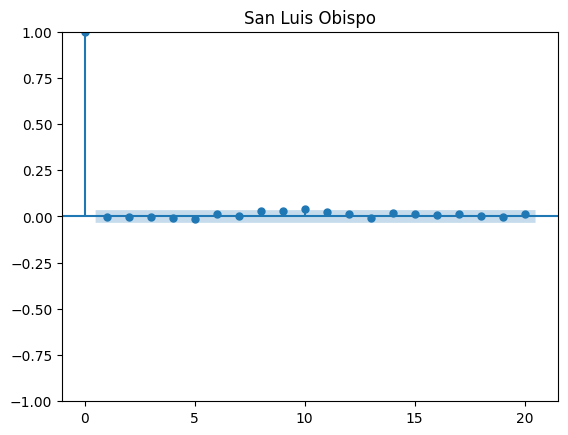

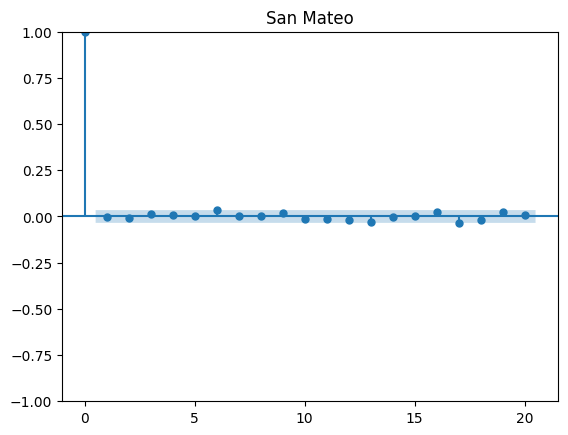

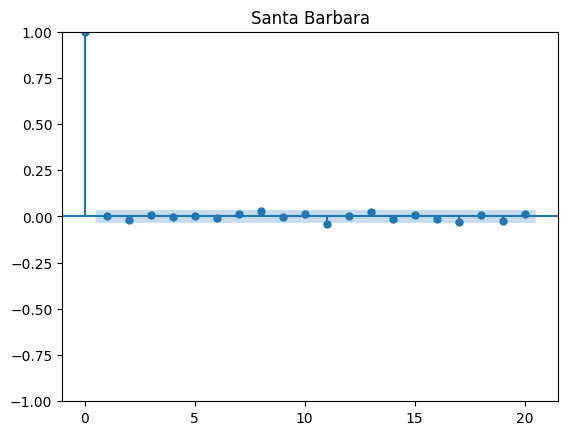

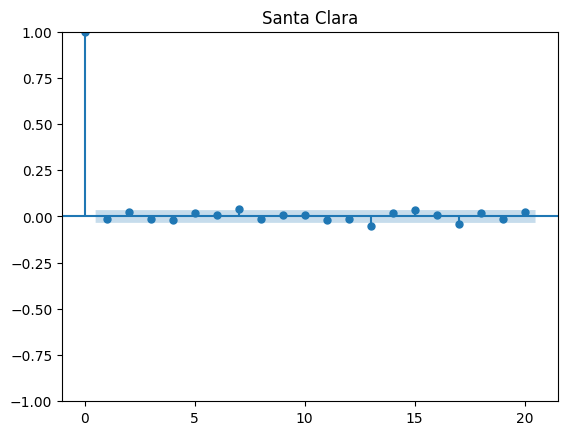

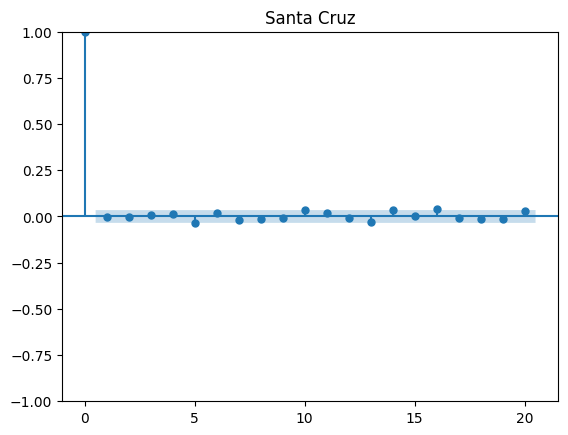

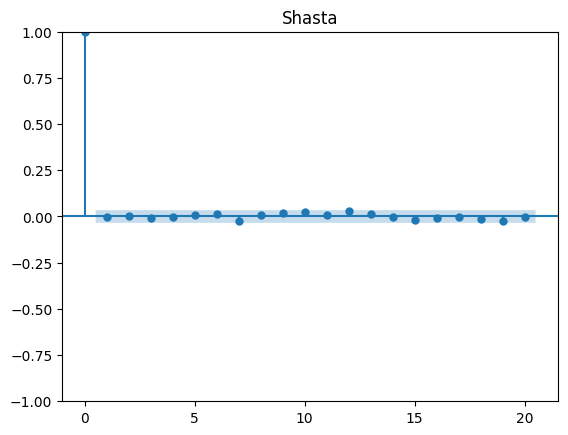

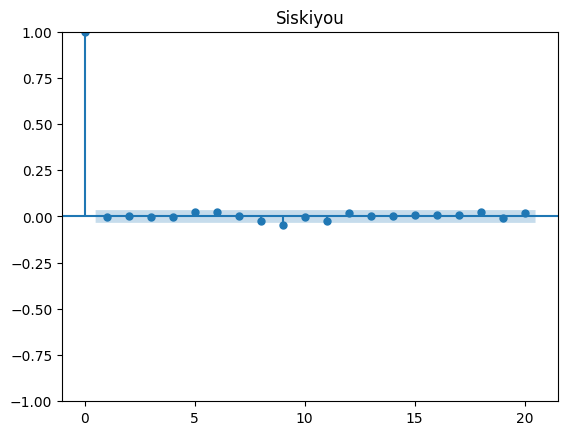

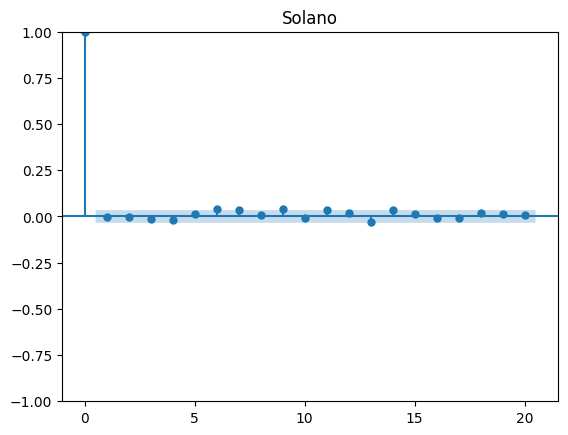

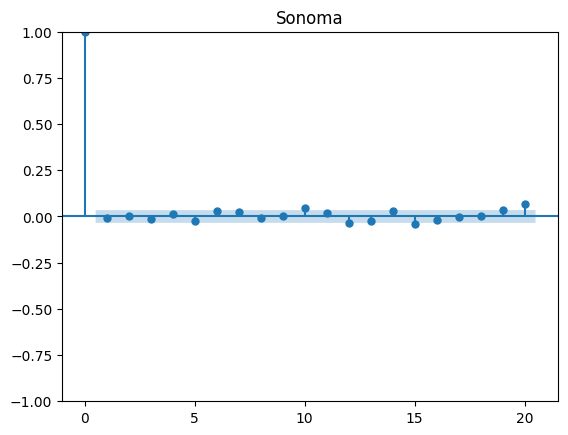

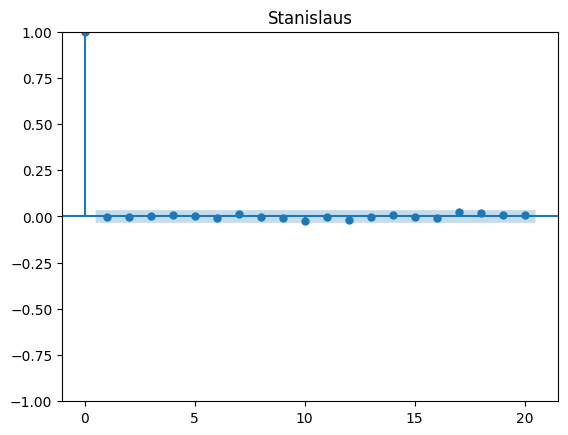

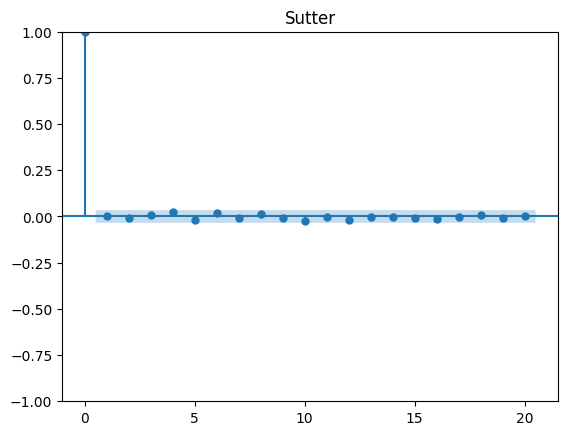

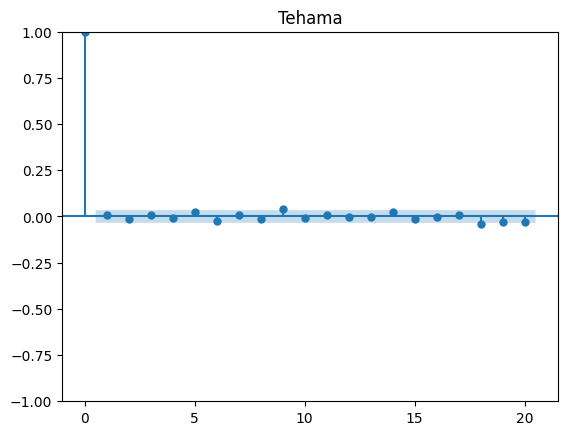

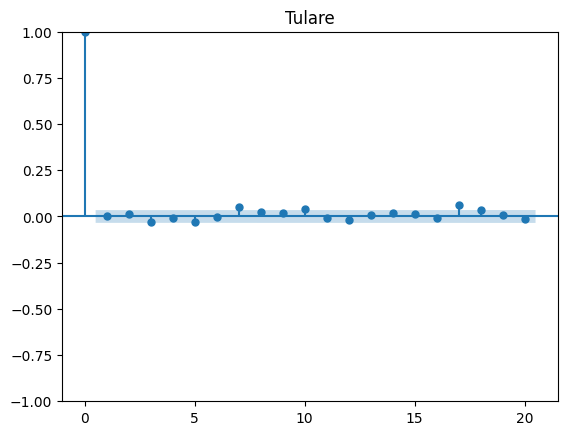

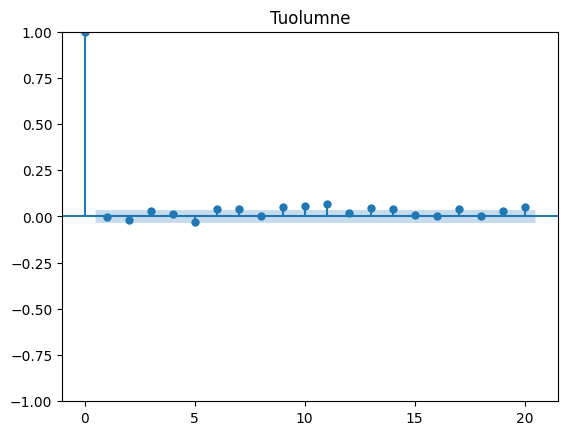

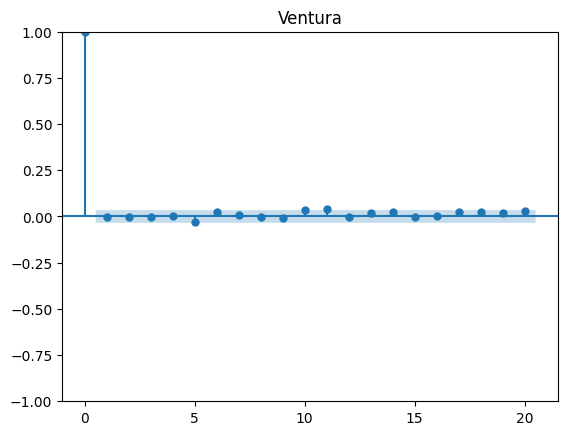

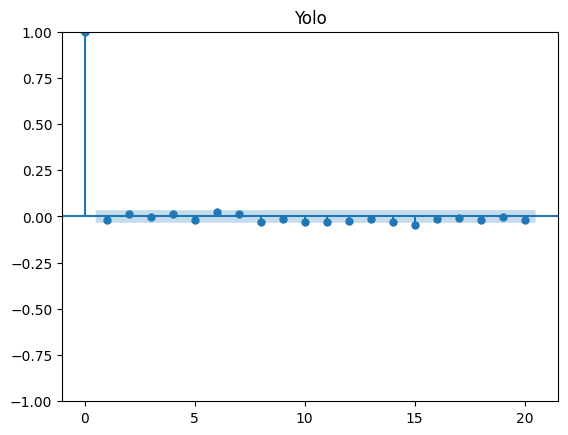

In [49]:
for col in ts_df.columns:
    sm.graphics.tsa.plot_acf(ts_df[col], lags=20,  title = col )



Fit Dygl

In [20]:
ts_df_scaled.shape

(2800, 50)

In [41]:
import DyGraph as dg
obs_per_graph = 100
dygl_aqi = dg.dygl_inner_em(ts_df_scaled, obs_per_graph=obs_per_graph, max_iter=1000, lamda= 0.02, kappa=0.5, lik_type='gaussian', tol=1e-3)
dygl_aqi.fit(temporal_penalty='element-wise')



Error 9.98E-4:  38%|███▊      | 381/1000 [00:59<01:36,  6.39it/s]


<AxesSubplot: >

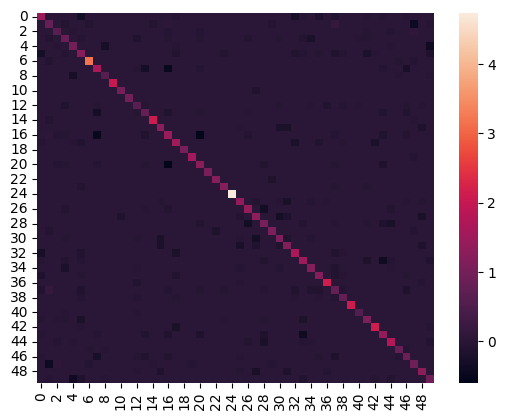

In [27]:
import seaborn as sns
sns.heatmap(dygl_aqi.theta[1])

<AxesSubplot: >

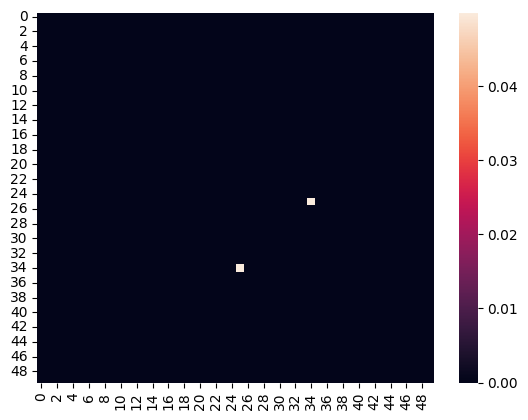

In [42]:
A = dygl_aqi.theta[1]-dygl_aqi.theta[0]
A[np.abs(A)<1e-3] = 0
np.fill_diagonal(A,0)
sns.heatmap(A)



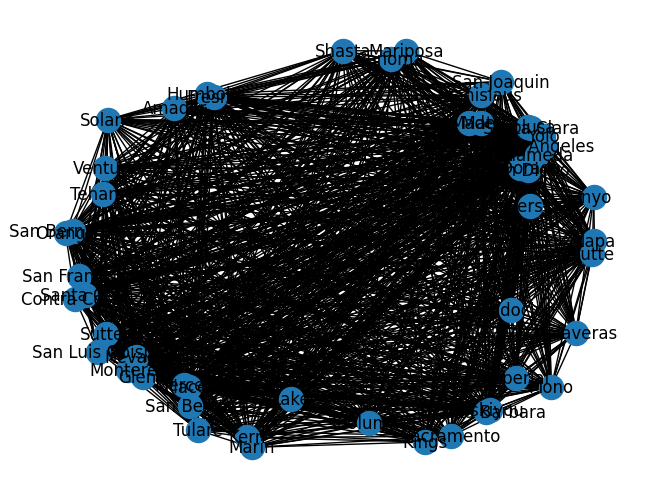

In [8]:

G = dygl_aqi.theta[0]
np.fill_diagonal(dygl_aqi.theta[0],0)
G = nx.from_numpy_array(G)
# nx.set_node_attributes(G, 'county', {i:n for i,n in enumerate(ts_df.columns)})
nx.draw(G, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True)

example of a graph from skater

Get longtidute and latitued

In [3]:
wikiurl="https://en.wikipedia.org/wiki/User:Michael_J/County_table"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
sites = pd.read_html(response.content)[-1]
sites = sites.loc[(sites['State'] == 'CA') & np.isin(sites['County [2]'], ts_df.columns)]
sites.head()


,Sort [1],State,FIPS,County [2],County Seat(s) [3],Population (2010),Land Area km²,Land Area mi²,Water Area km²,Water Area mi²,Total Area km²,Total Area mi²,Latitude,Longitude
186,187,CA,6001,Alameda,Oakland,1510271,1914.046,739.017,213.185,82.311,2127.231,821.328,+37.648081°,–121.913304°
188,189,CA,6005,Amador,Jackson,38091,1539.963,594.583,29.457,11.373,1569.420,605.956,+38.443550°,–120.653856°
189,190,CA,6007,Butte,Oroville,220000,4238.423,1636.464,105.326,40.667,4343.749,1677.131,+39.665959°,–121.601919°
190,191,CA,6009,Calaveras,San Andreas,45578,2641.820,1020.012,43.810,16.915,2685.630,1036.927,+38.187844°,–120.555115°
191,192,CA,6011,Colusa,Colusa,21419,2980.379,1150.731,14.581,5.630,2994.960,1156.361,+39.177739°,–122.237563°


convert lat and long to numbers (note - symbol is not the normal - symbol, its unicode is U+2013)

In [4]:
sites['Latitude'] = sites['Latitude'].str.replace('°','')
sites['Latitude'] = sites['Latitude'].str.replace('+','')
sites['Latitude'] = sites['Latitude'].str.replace('–','')
sites['Latitude'] = sites['Latitude'].astype(float)
sites['Longitude'] = sites['Longitude'].str.replace('°','')
sites['Longitude'] = sites['Longitude'].str.replace('+','')
sites['Longitude'] = sites['Longitude'].str.replace('–','')
sites['Longitude'] = sites['Longitude'].astype(float)

C:\Users\ragna\AppData\Local\Temp\ipykernel_2460\1098658906.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Latitude'] = sites['Latitude'].str.replace('+','')
C:\Users\ragna\AppData\Local\Temp\ipykernel_2460\1098658906.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Longitude'] = sites['Longitude'].str.replace('+','')


Construct geological adjacency matrix

In [5]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

   
locs = np.array(sites[['Latitude', 'Longitude']])
d = locs.shape[0]
R = np.zeros((d, d))

for i in range(d):
   for j in range(d):
      R[i,j] = distance(locs[i], locs[j])

Use slater

In [10]:
import geopandas as gpd
shape_in = gpd.read_file('../../ca-county-boundaries/CA_Counties/CA_COUNTIES_TIGER2016.shp')
shape_in.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [11]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
rpy2.robjects.numpy2ri.activate()
HDtest = importr('HDtest')
spdep  = importr('spdep')

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic 

def distance_in_km(x, y):
    return geodesic((x[0], x[1]), (y[0], y[1])).km
locs = np.array(sites[['Latitude', 'Longitude']])
distance_matrix = pairwise_distances(locs, metric=distance_in_km)
distance_matrix.shape


G_geo = nx.from_numpy_array(distance_matrix)
pos = {i:locs[i] for i in range(len(locs))}

edge_list = []
w_list = []
for e in G_geo.edges():
    edge_list.append(e)
    w_list.append(G_geo[e[0]][e[1]]['weight'])


# #Edges 
G_mst = nx.minimum_spanning_tree(G_geo )

# G_mst = nx.minimum_spanning_tree(G_geo)
# nx.set_node_attributes(G, 'county', {i:n for i,n in enumerate(ts_df.columns)})
#nx.draw(G_mst, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True, pos = pos)

In [12]:
df  = []

for y in range(2014,2023):
    d_tmp = pd.read_csv(f"../data/AQI/daily_aqi_by_county_{y}.csv")
    d_tmp = d_tmp.loc[d_tmp['State Name'] == 'California']
    d_tmp = d_tmp[['county Name', 'Date', 'AQI']].pivot(index = 'Date', columns='county Name', values='AQI')
    df.append(d_tmp)

df = pd.concat(df)
df_t = df.ffill().copy()
df_t = df_t.dropna(axis=1)
df_t = df_t.iloc[200:3000]

In [74]:
from datetime import datetime
values_aug_2019 = pd.DataFrame({'NAME':df_t.loc[(pd.to_datetime(df_t.index) <= datetime(2019,8,23)) & (pd.to_datetime(df_t.index) >= datetime(2019,7,23)) ].mean(axis = 0).keys(),
              'value':df_t.loc[(pd.to_datetime(df_t.index) <= datetime(2019,8,23)) & (pd.to_datetime(df_t.index) >= datetime(2019,7,23)) ].max(axis = 0).values} )
shape_in_2019 = pd.merge(shape_in,values_aug_2019,  how = 'left', on = 'NAME')
shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])
shape_in_2019 = shape_in_2019.loc[np.isin(shape_in_2019['NAME'], df_t.columns)]
shape_in_2019.shape

C:\Users\User\AppData\Local\Temp\ipykernel_26032\4276210948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])


(50, 19)

In [17]:
import libpysal
w = libpysal.weights.Queen.from_dataframe(shape_in_2019)

In [50]:
for i in W.from_networkx(G_geo,'weight'):
    print(i)

(0, {1: 141.48109820405344, 2: 225.63587123978758, 3: 133.60878198760642, 4: 172.14373708201327, 5: 30.31086259207256, 6: 174.70320964116928, 7: 223.33363700601456, 8: 221.09002326685103, 9: 381.47185633020575, 10: 784.894346228897, 11: 418.51373544913196, 12: 382.8239218893325, 13: 256.0475331757209, 14: 176.33314266147954, 15: 505.16136568500053, 16: 197.55498455670315, 17: 85.89881203292258, 18: 176.84146971951907, 19: 238.7691982094568, 20: 116.77160937551615, 21: 269.26777854995436, 22: 165.07352831742026, 23: 102.01891740618986, 24: 208.140247316799, 25: 578.2335732923281, 26: 188.31425402221544, 27: 689.1353991603628, 28: 102.23190113144321, 29: 136.6299057513494, 30: 600.9112380181971, 31: 693.5580335203923, 32: 99.08298067271629, 33: 64.82839100784625, 34: 283.3465816484662, 35: 48.07931079451487, 36: 384.22435800730517, 37: 51.35658290107812, 38: 71.02973741688555, 39: 345.7244170593786, 40: 440.66102946000836, 41: 68.76124558769392, 42: 133.5382379030493, 43: 80.971553092524

In [56]:
distance_matrix*(distance_matrix<100)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 76.39269143,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , 76.39269143,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [83]:
shape_in_to_skater.shape

(50, 34)

In [94]:
distance_matrix

array([[  0.        , 449.56036671,  74.58821604, ..., 170.0330357 ,
        157.52982214, 349.29445275],
       [449.56036671,   0.        , 407.71978225, ..., 327.25081442,
        600.06261461, 101.20769039],
       [ 74.58821604, 407.71978225,   0.        , ..., 182.91690533,
        224.32994526, 311.16491854],
       ...,
       [170.0330357 , 327.25081442, 182.91690533, ...,   0.        ,
        289.56460574, 228.63940178],
       [157.52982214, 600.06261461, 224.32994526, ..., 289.56460574,
          0.        , 498.91171671],
       [349.29445275, 101.20769039, 311.16491854, ..., 228.63940178,
        498.91171671,   0.        ]])

In [95]:
distance_matrix*(distance_matrix<200)

array([[  0.        ,   0.        ,  74.58821604, ..., 170.0330357 ,
        157.52982214,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 101.20769039],
       [ 74.58821604,   0.        ,   0.        , ..., 182.91690533,
          0.        ,   0.        ],
       ...,
       [170.0330357 ,   0.        , 182.91690533, ...,   0.        ,
          0.        ,   0.        ],
       [157.52982214,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 101.20769039,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [92]:
import spopt
from libpysal.weights import W
from sklearn.metrics import pairwise as skm
import libpysal
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=np.sum,
    center=np.mean,
    verbose=False
)

sites['NAME'] = sites['County [2]']
shape_in_to_skater = pd.merge(shape_in_2019, sites,  how = 'left', on = 'NAME')

def distance_in_km(x, y):
    return geodesic((x[0], x[1]), (y[0], y[1])).km
locs = np.array(shape_in_to_skater[['Latitude', 'Longitude']])
distance_matrix = pairwise_distances(locs, metric=distance_in_km)
distance_matrix.shape


G_geo = nx.from_numpy_array(distance_matrix*(distance_matrix<200))
G_mst = nx.minimum_spanning_tree(G_geo )
model = spopt.region.Skater(
    shape_in_to_skater,
    W.from_networkx(G_geo,'weight'), #libpysal.weights.Queen.from_dataframe(shape_in_2019), #
    ["value"],
    n_clusters=4,
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()
shape_in_to_skater["demo_regions"] = model.labels_

(-13914886.987877835,
 -12647417.311524622,
 3766456.9557220647,
 5228877.504468495)

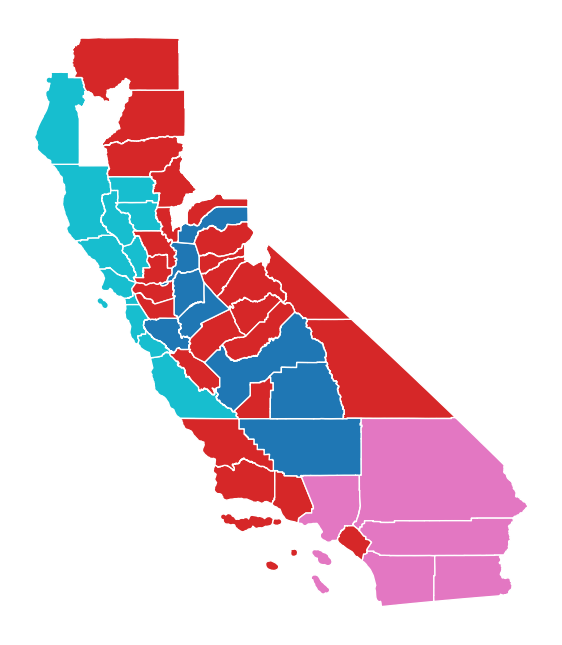

In [93]:
shape_in_to_skater.plot(
    figsize=(7, 14), column="demo_regions", categorical=True, edgecolor="w"
).axis("off")

<AxesSubplot: >

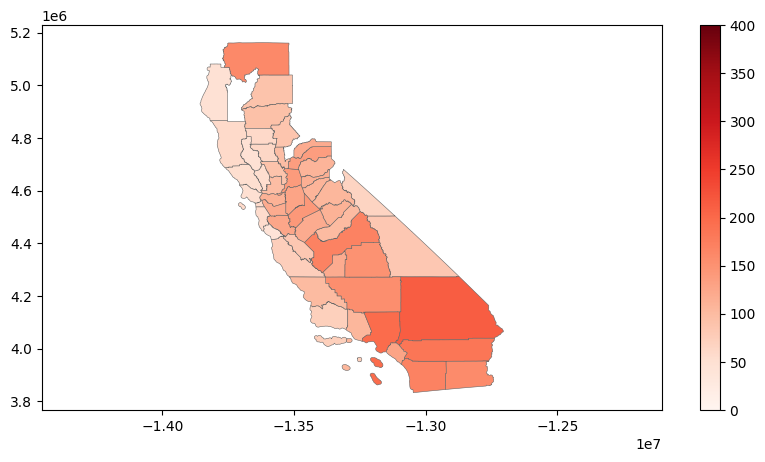

In [54]:
coord_list_spatial= []
node_pos_list = []


for e in G_mst.edges():
    
    n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[0]]]['geometry'].centroid
    n2 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[1]]]['geometry'].centroid
    coord_list_spatial.append(((n1.x.iloc[0], n1.y.iloc[0]), (n2.x.iloc[0], n2.y.iloc[0])))

for node in G_mst.nodes():
    n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[node]]['geometry'].centroid
    node_pos_list.append((n1.x.iloc[0], n1.y.iloc[0]))

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.set_aspect('equal', 'datalim')

shape_in_2019.plot(ax = ax, column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)


Text(0.5, 1.0, 'August 2019')

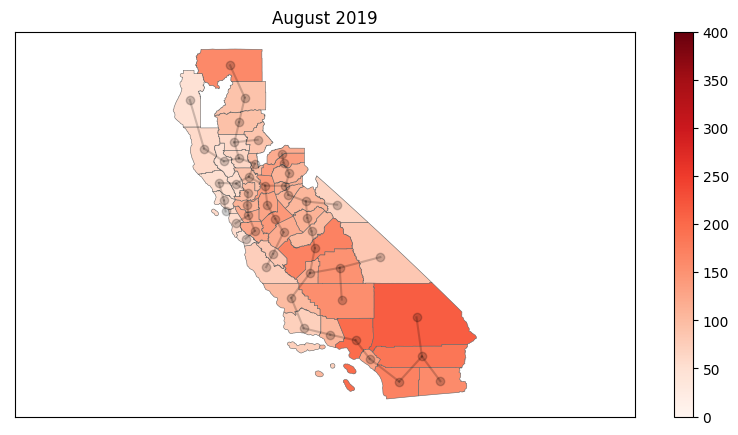

In [153]:
coord_list_spatial= []
node_pos_list = []


for e in G_mst.edges():
    
    n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[0]]]['geometry'].centroid
    n2 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[1]]]['geometry'].centroid
    coord_list_spatial.append(((n1.x.iloc[0], n1.y.iloc[0]), (n2.x.iloc[0], n2.y.iloc[0])))

for node in G_mst.nodes():
    n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[node]]['geometry'].centroid
    node_pos_list.append((n1.x.iloc[0], n1.y.iloc[0]))

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.set_aspect('equal', 'datalim')

shape_in_2019.plot(ax = ax, column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)




for i in range(len(coord_list_spatial)):
    ax.plot((coord_list_spatial[i][0][0], coord_list_spatial[i][1][0]), (coord_list_spatial[i][0][1], coord_list_spatial[i][1][1]), color = "black", alpha = 0.2)
for i in range(len(node_pos_list)):
    ax.scatter(node_pos_list[i][0], node_pos_list[i][1], color = "black", alpha = 0.2)


ax.set_xticks([])
ax.set_yticks([])


ax.set_title('August 2019')


In [162]:
import libpysal
import geopandas
libpysal.examples.load_example("AirBnB")
chicago = geopandas.read_file(libpysal.examples.get_path("airbnb_Chicago 2015.shp"))
chicago.shape

(77, 21)

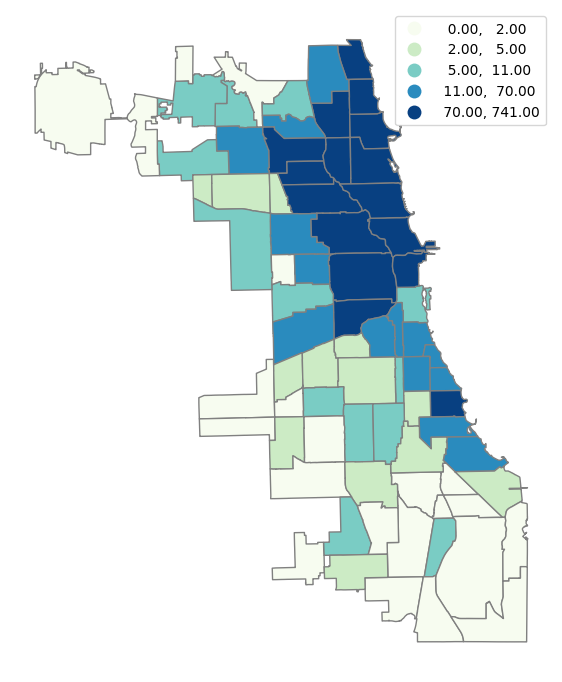

In [163]:
chicago.plot(
    figsize=(7, 14),
    column="num_spots",
    scheme="Quantiles",
    cmap="GnBu",
    edgecolor="grey",
    legend=True
).axis("off");

In [170]:
chicago['num_spots']

0      38
1      20
2       6
3      30
4      39
     ... 
72      0
73      5
74      2
75    170
76      1
Name: num_spots, Length: 77, dtype: int64

In [166]:
attrs_name = ["num_spots"]
w = libpysal.weights.Queen.from_dataframe(chicago)

for i in w:
    print(i)

(0, {33: 1.0, 34: 1.0, 3: 1.0, 1: 1.0})
(1, {0: 1.0, 3: 1.0, 4: 1.0})
(2, {65: 1.0, 34: 1.0, 3: 1.0, 6: 1.0, 57: 1.0, 58: 1.0})
(3, {0: 1.0, 1: 1.0, 34: 1.0, 2: 1.0, 4: 1.0, 6: 1.0, 7: 1.0})
(4, {1: 1.0, 3: 1.0, 6: 1.0, 7: 1.0})
(5, {75: 1.0, 12: 1.0, 13: 1.0, 45: 1.0, 15: 1.0, 19: 1.0, 56: 1.0, 30: 1.0})
(6, {65: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 66: 1.0, 7: 1.0, 8: 1.0})
(7, {8: 1.0, 3: 1.0, 4: 1.0, 6: 1.0})
(8, {38: 1.0, 66: 1.0, 6: 1.0, 7: 1.0})
(9, {19: 1.0, 75: 1.0})
(10, {11: 1.0, 35: 1.0, 14: 1.0})
(11, {35: 1.0, 10: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0})
(12, {11: 1.0, 13: 1.0, 19: 1.0, 5: 1.0})
(13, {5: 1.0, 11: 1.0, 12: 1.0, 45: 1.0, 14: 1.0, 15: 1.0})
(14, {16: 1.0, 18: 1.0, 20: 1.0, 10: 1.0, 11: 1.0, 13: 1.0, 15: 1.0})
(15, {45: 1.0, 20: 1.0, 5: 1.0, 21: 1.0, 11: 1.0, 13: 1.0, 14: 1.0})
(16, {17: 1.0, 18: 1.0, 74: 1.0, 14: 1.0})
(17, {16: 1.0, 25: 1.0, 18: 1.0})
(18, {16: 1.0, 17: 1.0, 20: 1.0, 23: 1.0, 25: 1.0, 14: 1.0})
(19, {9: 1.0, 75: 1.0, 12: 1.0, 5: 1.0})
(20, {18: 1.